In [1]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm as tqdm
import os
from torchvision.models import resnet34
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('/home/sauravpathak/acoustic_scene_classification_small/train_split_df.pkl')
np.random.shuffle(df.values)
print('df loaded')

df loaded


In [5]:
dataset_size = len(df)

In [7]:
def get_melspectrogram_db(file_path, sr = 48000, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=24000, top_db=80):
    wav,sr = librosa.load(file_path, sr = sr)
    if wav.shape[0]<2*sr:
        wav=np.pad(wav,int(np.ceil((2*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:2*sr]
    spec=librosa.feature.melspectrogram(wav,sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [8]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 1 * (spec_norm - spec_min) / (spec_max - spec_min)
    return spec_scaled

In [13]:
class AudioData(Dataset):
    def __init__(self, df, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = df.iloc[ind,1]
            self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            self.labels.append(self.c2i[row['label']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [14]:
train_df = df.iloc[:int(np.floor(dataset_size)*0.8)]
valid_df = df.iloc[int(np.floor(dataset_size)*0.8):]
train_data = AudioData(train_df, 'label')
valid_data = AudioData(valid_df, 'label')

100%|██████████| 646/646 [00:07<00:00, 85.25it/s]


In [15]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [17]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')
resnet_model = resnet34(pretrained=False)
resnet_model.fc = nn.Linear(512,7)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

In [18]:
train_acc = []
valid_acc = []
train_losses = []
valid_losses = []

In [19]:
from torch.optim.lr_scheduler import StepLR

In [20]:
learning_rate = 1e-3

In [21]:
epochs = 100

In [22]:
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, scheduler):
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())  
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        scheduler.step()
        train_losses.append(np.mean(batch_losses))
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        train_acc.append(accuracy)
        print(f'Epoch - {epoch} Train-Loss : {train_losses[-1]} Train-Accuracy : {accuracy}')
        with torch.no_grad():
            model.eval()
            batch_losses=[]
            trace_y = []
            trace_yhat = []
            for i, data in enumerate(valid_loader):
                x, y = data
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.long)
                y_hat = model(x)
                loss = loss_fn(y_hat, y)
                trace_y.append(y.cpu().detach().numpy())
                trace_yhat.append(y_hat.cpu().detach().numpy())      
                batch_losses.append(loss.item())
            valid_losses.append(np.mean(batch_losses))
            trace_y = np.concatenate(trace_y)
            trace_yhat = np.concatenate(trace_yhat)
            accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
            valid_acc.append(accuracy)
            print(f'Epoch - {epoch} Valid-Loss : {valid_losses[-1]} Valid-Accuracy : {accuracy}')

In [23]:
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, scheduler)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.49828565194283 Train-Accuracy : 0.4102167182662539


  1%|          | 1/100 [00:22<37:05, 22.48s/it]

Epoch - 1 Valid-Loss : 1.3240475523762587 Valid-Accuracy : 0.4613003095975232
Epoch - 2 Train-Loss : 1.2948992793206815 Train-Accuracy : 0.4791021671826625


  2%|▏         | 2/100 [00:44<36:27, 22.32s/it]

Epoch - 2 Valid-Loss : 1.2963280256201581 Valid-Accuracy : 0.456656346749226
Epoch - 3 Train-Loss : 1.1959918958169442 Train-Accuracy : 0.5116099071207431


  3%|▎         | 3/100 [01:06<35:56, 22.24s/it]

Epoch - 3 Valid-Loss : 1.1134308082301443 Valid-Accuracy : 0.5371517027863777
Epoch - 4 Train-Loss : 1.1551984390358867 Train-Accuracy : 0.5344427244582043


  4%|▍         | 4/100 [01:28<35:26, 22.15s/it]

Epoch - 4 Valid-Loss : 1.3342156817273396 Valid-Accuracy : 0.456656346749226
Epoch - 5 Train-Loss : 1.120445277587867 Train-Accuracy : 0.5487616099071208


  5%|▌         | 5/100 [01:50<35:05, 22.16s/it]

Epoch - 5 Valid-Loss : 2.3231572726877725 Valid-Accuracy : 0.413312693498452
Epoch - 6 Train-Loss : 1.0708945268466148 Train-Accuracy : 0.5770123839009288


  6%|▌         | 6/100 [02:12<34:35, 22.08s/it]

Epoch - 6 Valid-Loss : 1.2342189375947161 Valid-Accuracy : 0.49226006191950467
Epoch - 7 Train-Loss : 1.0113164355725417 Train-Accuracy : 0.6048761609907121


  7%|▋         | 7/100 [02:34<34:16, 22.12s/it]

Epoch - 7 Valid-Loss : 1.302442934454941 Valid-Accuracy : 0.47678018575851394
Epoch - 8 Train-Loss : 1.0045906106630962 Train-Accuracy : 0.6013931888544891


  8%|▊         | 8/100 [02:56<33:46, 22.03s/it]

Epoch - 8 Valid-Loss : 3.6450874921752185 Valid-Accuracy : 0.23529411764705882
Epoch - 9 Train-Loss : 0.9594295826959022 Train-Accuracy : 0.6269349845201239


  9%|▉         | 9/100 [03:18<33:25, 22.04s/it]

Epoch - 9 Valid-Loss : 1.238826194914376 Valid-Accuracy : 0.5402476780185759
Epoch - 10 Train-Loss : 0.9245085129399359 Train-Accuracy : 0.6486068111455109


 10%|█         | 10/100 [03:40<33:05, 22.06s/it]

Epoch - 10 Valid-Loss : 1.0617306872111996 Valid-Accuracy : 0.5526315789473685
Epoch - 11 Train-Loss : 0.7497193835399769 Train-Accuracy : 0.7171052631578947


 11%|█         | 11/100 [04:02<32:40, 22.03s/it]

Epoch - 11 Valid-Loss : 0.6956171175328697 Valid-Accuracy : 0.718266253869969
Epoch - 12 Train-Loss : 0.6597716295056872 Train-Accuracy : 0.7426470588235294


 12%|█▏        | 12/100 [04:24<32:18, 22.02s/it]

Epoch - 12 Valid-Loss : 0.6501949000649336 Valid-Accuracy : 0.7368421052631579
Epoch - 13 Train-Loss : 0.6167365627156364 Train-Accuracy : 0.7647058823529411


 13%|█▎        | 13/100 [04:46<31:55, 22.01s/it]

Epoch - 13 Valid-Loss : 0.6511845450575758 Valid-Accuracy : 0.7678018575851393
Epoch - 14 Train-Loss : 0.5505894298354784 Train-Accuracy : 0.7995356037151703


 14%|█▍        | 14/100 [05:08<31:32, 22.01s/it]

Epoch - 14 Valid-Loss : 0.5715405054208709 Valid-Accuracy : 0.7678018575851393
Epoch - 15 Train-Loss : 0.5096757275822722 Train-Accuracy : 0.8115325077399381


 15%|█▌        | 15/100 [05:30<31:08, 21.99s/it]

Epoch - 15 Valid-Loss : 0.6441749054484252 Valid-Accuracy : 0.7585139318885449
Epoch - 16 Train-Loss : 0.4836805856522219 Train-Accuracy : 0.8212074303405573


 16%|█▌        | 16/100 [05:52<30:45, 21.97s/it]

Epoch - 16 Valid-Loss : 0.616895911897101 Valid-Accuracy : 0.7554179566563467
Epoch - 17 Train-Loss : 0.444428445564376 Train-Accuracy : 0.8351393188854489


 17%|█▋        | 17/100 [06:14<30:23, 21.97s/it]

Epoch - 17 Valid-Loss : 0.6245338026343322 Valid-Accuracy : 0.7554179566563467
Epoch - 18 Train-Loss : 0.40376630397858443 Train-Accuracy : 0.8568111455108359


 18%|█▊        | 18/100 [06:36<30:00, 21.95s/it]

Epoch - 18 Valid-Loss : 0.7061559009115871 Valid-Accuracy : 0.7507739938080495
Epoch - 19 Train-Loss : 0.391837227123755 Train-Accuracy : 0.8610681114551083


 19%|█▉        | 19/100 [06:58<29:35, 21.93s/it]

Epoch - 19 Valid-Loss : 0.5943076639640622 Valid-Accuracy : 0.7678018575851393
Epoch - 20 Train-Loss : 0.3377372754484783 Train-Accuracy : 0.8796439628482973


 20%|██        | 20/100 [07:20<29:11, 21.89s/it]

Epoch - 20 Valid-Loss : 0.6740794719719305 Valid-Accuracy : 0.7507739938080495
Epoch - 21 Train-Loss : 0.2206483244160075 Train-Accuracy : 0.9276315789473685


 21%|██        | 21/100 [07:41<28:48, 21.88s/it]

Epoch - 21 Valid-Loss : 0.3418278254386855 Valid-Accuracy : 0.8746130030959752
Epoch - 22 Train-Loss : 0.17904452091933767 Train-Accuracy : 0.9438854489164087


 22%|██▏       | 22/100 [08:03<28:26, 21.88s/it]

Epoch - 22 Valid-Loss : 0.32839475935552176 Valid-Accuracy : 0.8931888544891641
Epoch - 23 Train-Loss : 0.1419424894783232 Train-Accuracy : 0.9585913312693498


 23%|██▎       | 23/100 [08:25<28:04, 21.87s/it]

Epoch - 23 Valid-Loss : 0.3412417200643842 Valid-Accuracy : 0.871517027863777
Epoch - 24 Train-Loss : 0.13796819424555626 Train-Accuracy : 0.9574303405572755


 24%|██▍       | 24/100 [08:47<27:44, 21.91s/it]

Epoch - 24 Valid-Loss : 0.3413013289341839 Valid-Accuracy : 0.8606811145510835
Epoch - 25 Train-Loss : 0.1127219490798903 Train-Accuracy : 0.9640092879256966


 25%|██▌       | 25/100 [09:09<27:22, 21.89s/it]

Epoch - 25 Valid-Loss : 0.32628861796565173 Valid-Accuracy : 0.871517027863777
Epoch - 26 Train-Loss : 0.11231593028814704 Train-Accuracy : 0.9636222910216719


 26%|██▌       | 26/100 [09:31<27:01, 21.91s/it]

Epoch - 26 Valid-Loss : 0.33647232884314004 Valid-Accuracy : 0.8653250773993808
Epoch - 27 Train-Loss : 0.11109903537564808 Train-Accuracy : 0.9678792569659442


 27%|██▋       | 27/100 [09:53<26:39, 21.90s/it]

Epoch - 27 Valid-Loss : 0.35118719717351404 Valid-Accuracy : 0.8839009287925697
Epoch - 28 Train-Loss : 0.09205716402258401 Train-Accuracy : 0.9760061919504643


 28%|██▊       | 28/100 [10:15<26:18, 21.92s/it]

Epoch - 28 Valid-Loss : 0.3500039475720103 Valid-Accuracy : 0.868421052631579
Epoch - 29 Train-Loss : 0.08629805268144902 Train-Accuracy : 0.9767801857585139


 29%|██▉       | 29/100 [10:37<25:57, 21.94s/it]

Epoch - 29 Valid-Loss : 0.32642799688548574 Valid-Accuracy : 0.8900928792569659
Epoch - 30 Train-Loss : 0.08596846718847016 Train-Accuracy : 0.9698142414860681


 30%|███       | 30/100 [10:59<25:34, 21.93s/it]

Epoch - 30 Valid-Loss : 0.32656158107083016 Valid-Accuracy : 0.8839009287925697
Epoch - 31 Train-Loss : 0.06515441158855403 Train-Accuracy : 0.9864551083591331


 31%|███       | 31/100 [11:21<25:14, 21.95s/it]

Epoch - 31 Valid-Loss : 0.3063910127412982 Valid-Accuracy : 0.8947368421052632
Epoch - 32 Train-Loss : 0.0573773714311329 Train-Accuracy : 0.9849071207430341


 32%|███▏      | 32/100 [11:43<25:06, 22.15s/it]

Epoch - 32 Valid-Loss : 0.31878453747528357 Valid-Accuracy : 0.8931888544891641
Epoch - 33 Train-Loss : 0.0463980499792982 Train-Accuracy : 0.9891640866873065


 33%|███▎      | 33/100 [12:07<25:07, 22.50s/it]

Epoch - 33 Valid-Loss : 0.29846404947158767 Valid-Accuracy : 0.8993808049535603
Epoch - 34 Train-Loss : 0.050562633868352864 Train-Accuracy : 0.9876160990712074


 34%|███▍      | 34/100 [12:30<25:02, 22.76s/it]

Epoch - 34 Valid-Loss : 0.30708493237815254 Valid-Accuracy : 0.8931888544891641
Epoch - 35 Train-Loss : 0.04424422905768877 Train-Accuracy : 0.9910990712074303


 35%|███▌      | 35/100 [12:52<24:26, 22.57s/it]

Epoch - 35 Valid-Loss : 0.3028023410134199 Valid-Accuracy : 0.8885448916408669
Epoch - 36 Train-Loss : 0.04950759118353879 Train-Accuracy : 0.9864551083591331


 36%|███▌      | 36/100 [13:14<23:52, 22.38s/it]

Epoch - 36 Valid-Loss : 0.31360882175404853 Valid-Accuracy : 0.8900928792569659
Epoch - 37 Train-Loss : 0.042007327217746665 Train-Accuracy : 0.9914860681114551


 37%|███▋      | 37/100 [13:36<23:26, 22.32s/it]

Epoch - 37 Valid-Loss : 0.31090814352217244 Valid-Accuracy : 0.8869969040247678
Epoch - 38 Train-Loss : 0.0350741991934217 Train-Accuracy : 0.9941950464396285


 38%|███▊      | 38/100 [13:58<22:57, 22.22s/it]

Epoch - 38 Valid-Loss : 0.28902997560912697 Valid-Accuracy : 0.8978328173374613
Epoch - 39 Train-Loss : 0.028542057231620507 Train-Accuracy : 0.9969040247678018


 39%|███▉      | 39/100 [14:20<22:31, 22.16s/it]

Epoch - 39 Valid-Loss : 0.28692979033945537 Valid-Accuracy : 0.9040247678018576
Epoch - 40 Train-Loss : 0.03526352419529432 Train-Accuracy : 0.9918730650154799


 40%|████      | 40/100 [14:42<22:06, 22.11s/it]

Epoch - 40 Valid-Loss : 0.29301961129758414 Valid-Accuracy : 0.9102167182662538
Epoch - 41 Train-Loss : 0.033012128400581854 Train-Accuracy : 0.993421052631579


 41%|████      | 41/100 [15:04<21:34, 21.94s/it]

Epoch - 41 Valid-Loss : 0.2894484896848841 Valid-Accuracy : 0.9055727554179567
Epoch - 42 Train-Loss : 0.03232896488941746 Train-Accuracy : 0.9953560371517027


 42%|████▏     | 42/100 [15:26<21:13, 21.95s/it]

Epoch - 42 Valid-Loss : 0.2878731026700357 Valid-Accuracy : 0.8978328173374613
Epoch - 46 Train-Loss : 0.031024929228020304 Train-Accuracy : 0.9945820433436533


 46%|████▌     | 46/100 [16:54<19:46, 21.98s/it]

Epoch - 46 Valid-Loss : 0.2864344430769362 Valid-Accuracy : 0.9040247678018576
Epoch - 47 Train-Loss : 0.03050377826999735 Train-Accuracy : 0.9945820433436533


 47%|████▋     | 47/100 [17:16<19:26, 22.00s/it]

Epoch - 47 Valid-Loss : 0.2962153133277486 Valid-Accuracy : 0.9024767801857585
Epoch - 48 Train-Loss : 0.03441200037429362 Train-Accuracy : 0.9926470588235294


 48%|████▊     | 48/100 [17:38<19:04, 22.00s/it]

Epoch - 48 Valid-Loss : 0.29622946497870656 Valid-Accuracy : 0.8978328173374613
Epoch - 49 Train-Loss : 0.028317071267484145 Train-Accuracy : 0.9945820433436533


 49%|████▉     | 49/100 [18:00<18:41, 21.99s/it]

Epoch - 49 Valid-Loss : 0.300765104410125 Valid-Accuracy : 0.9024767801857585
Epoch - 50 Train-Loss : 0.027127361270012678 Train-Accuracy : 0.996517027863777


 50%|█████     | 50/100 [18:22<18:19, 21.99s/it]

Epoch - 50 Valid-Loss : 0.2961042904999198 Valid-Accuracy : 0.9040247678018576
Epoch - 51 Train-Loss : 0.0312180706748256 Train-Accuracy : 0.9945820433436533


 51%|█████     | 51/100 [18:44<17:57, 22.00s/it]

Epoch - 51 Valid-Loss : 0.2882989019882388 Valid-Accuracy : 0.8993808049535603
Epoch - 52 Train-Loss : 0.027593220595592334 Train-Accuracy : 0.9953560371517027


 52%|█████▏    | 52/100 [19:06<17:35, 21.99s/it]

Epoch - 52 Valid-Loss : 0.28744218080509 Valid-Accuracy : 0.9071207430340558
Epoch - 53 Train-Loss : 0.02992620406511389 Train-Accuracy : 0.9949690402476781


 53%|█████▎    | 53/100 [19:28<17:13, 22.00s/it]

Epoch - 53 Valid-Loss : 0.2974368656599304 Valid-Accuracy : 0.8993808049535603
Epoch - 54 Train-Loss : 0.02706894963795756 Train-Accuracy : 0.9957430340557275


 54%|█████▍    | 54/100 [19:50<16:52, 22.01s/it]

Epoch - 54 Valid-Loss : 0.29106696077236316 Valid-Accuracy : 0.9040247678018576
Epoch - 55 Train-Loss : 0.030744081891981172 Train-Accuracy : 0.996517027863777


 55%|█████▌    | 55/100 [20:13<16:47, 22.40s/it]

Epoch - 55 Valid-Loss : 0.28771624977632265 Valid-Accuracy : 0.9086687306501547
Epoch - 56 Train-Loss : 0.027006365680768165 Train-Accuracy : 0.9969040247678018


 56%|█████▌    | 56/100 [20:36<16:37, 22.68s/it]

Epoch - 56 Valid-Loss : 0.2852543790529414 Valid-Accuracy : 0.9055727554179567
Epoch - 57 Train-Loss : 0.02655887622156261 Train-Accuracy : 0.9980650154798761


 57%|█████▋    | 57/100 [21:00<16:24, 22.90s/it]

Epoch - 57 Valid-Loss : 0.2810952928124518 Valid-Accuracy : 0.9009287925696594
Epoch - 58 Train-Loss : 0.029818197551332873 Train-Accuracy : 0.9945820433436533


 58%|█████▊    | 58/100 [21:23<16:07, 23.04s/it]

Epoch - 58 Valid-Loss : 0.28735784884178783 Valid-Accuracy : 0.9024767801857585
Epoch - 59 Train-Loss : 0.027486351491124543 Train-Accuracy : 0.9941950464396285


 59%|█████▉    | 59/100 [21:47<15:50, 23.18s/it]

Epoch - 59 Valid-Loss : 0.29556842148303986 Valid-Accuracy : 0.9055727554179567
Epoch - 60 Train-Loss : 0.02597636260368206 Train-Accuracy : 0.996517027863777


 60%|██████    | 60/100 [22:09<15:13, 22.84s/it]

Epoch - 60 Valid-Loss : 0.28807922834303323 Valid-Accuracy : 0.9040247678018576
Epoch - 61 Train-Loss : 0.030276857408476465 Train-Accuracy : 0.9949690402476781


 61%|██████    | 61/100 [22:31<14:40, 22.58s/it]

Epoch - 61 Valid-Loss : 0.2857458426094637 Valid-Accuracy : 0.9040247678018576
Epoch - 62 Train-Loss : 0.020925465925240222 Train-Accuracy : 0.9980650154798761


 62%|██████▏   | 62/100 [22:53<14:10, 22.37s/it]

Epoch - 62 Valid-Loss : 0.28604104478911657 Valid-Accuracy : 0.9055727554179567
Epoch - 63 Train-Loss : 0.024015209649080112 Train-Accuracy : 0.996517027863777


 63%|██████▎   | 63/100 [23:15<13:43, 22.25s/it]

Epoch - 63 Valid-Loss : 0.28207292741664297 Valid-Accuracy : 0.9071207430340558
Epoch - 64 Train-Loss : 0.029232867430021733 Train-Accuracy : 0.9949690402476781


 64%|██████▍   | 64/100 [23:37<13:17, 22.16s/it]

Epoch - 64 Valid-Loss : 0.2838555396330066 Valid-Accuracy : 0.9117647058823529
Epoch - 65 Train-Loss : 0.02766112274961707 Train-Accuracy : 0.9957430340557275


 65%|██████▌   | 65/100 [23:58<12:52, 22.09s/it]

Epoch - 65 Valid-Loss : 0.2995743289953325 Valid-Accuracy : 0.8978328173374613
Epoch - 66 Train-Loss : 0.02738450007674135 Train-Accuracy : 0.9961300309597523


 66%|██████▌   | 66/100 [24:20<12:29, 22.04s/it]

Epoch - 66 Valid-Loss : 0.2857715734621374 Valid-Accuracy : 0.9040247678018576
Epoch - 67 Train-Loss : 0.028061355475658252 Train-Accuracy : 0.9941950464396285


 67%|██████▋   | 67/100 [24:42<12:07, 22.06s/it]

Epoch - 67 Valid-Loss : 0.2820201401666897 Valid-Accuracy : 0.9086687306501547
Epoch - 68 Train-Loss : 0.02793460265721804 Train-Accuracy : 0.9961300309597523


 68%|██████▊   | 68/100 [25:04<11:44, 22.00s/it]

Epoch - 68 Valid-Loss : 0.28760986720643394 Valid-Accuracy : 0.9102167182662538
Epoch - 69 Train-Loss : 0.02309728721961563 Train-Accuracy : 0.9972910216718266


 69%|██████▉   | 69/100 [25:26<11:22, 22.01s/it]

Epoch - 69 Valid-Loss : 0.28934287261672137 Valid-Accuracy : 0.9086687306501547
Epoch - 70 Train-Loss : 0.025702205705054014 Train-Accuracy : 0.9961300309597523


 70%|███████   | 70/100 [25:48<10:59, 21.98s/it]

Epoch - 70 Valid-Loss : 0.28326072914116995 Valid-Accuracy : 0.9040247678018576
Epoch - 71 Train-Loss : 0.024328430539663926 Train-Accuracy : 0.996517027863777


 71%|███████   | 71/100 [26:10<10:36, 21.96s/it]

Epoch - 71 Valid-Loss : 0.2933612569439702 Valid-Accuracy : 0.9040247678018576
Epoch - 72 Train-Loss : 0.026769541387940632 Train-Accuracy : 0.9957430340557275


 72%|███████▏  | 72/100 [26:32<10:15, 21.97s/it]

Epoch - 72 Valid-Loss : 0.2866939031859724 Valid-Accuracy : 0.9024767801857585
Epoch - 73 Train-Loss : 0.026155141078763537 Train-Accuracy : 0.9961300309597523


 73%|███████▎  | 73/100 [26:54<09:53, 21.98s/it]

Epoch - 73 Valid-Loss : 0.2806029971234682 Valid-Accuracy : 0.9071207430340558
Epoch - 74 Train-Loss : 0.027808672024144068 Train-Accuracy : 0.996517027863777


 74%|███████▍  | 74/100 [27:16<09:31, 22.00s/it]

Epoch - 74 Valid-Loss : 0.287283186687202 Valid-Accuracy : 0.9071207430340558
Epoch - 75 Train-Loss : 0.027083631742883613 Train-Accuracy : 0.9953560371517027


 75%|███████▌  | 75/100 [27:38<09:09, 21.98s/it]

Epoch - 75 Valid-Loss : 0.2908888043063443 Valid-Accuracy : 0.9009287925696594
Epoch - 76 Train-Loss : 0.024277692315755068 Train-Accuracy : 0.9972910216718266


 76%|███████▌  | 76/100 [28:00<08:47, 21.97s/it]

Epoch - 76 Valid-Loss : 0.29842988383479235 Valid-Accuracy : 0.9040247678018576
Epoch - 77 Train-Loss : 0.024689777811736237 Train-Accuracy : 0.9976780185758514


 77%|███████▋  | 77/100 [28:22<08:25, 21.99s/it]

Epoch - 77 Valid-Loss : 0.2894290129585964 Valid-Accuracy : 0.9024767801857585
Epoch - 81 Train-Loss : 0.02797160992099915 Train-Accuracy : 0.9961300309597523


 81%|████████  | 81/100 [29:50<06:57, 21.99s/it]

Epoch - 81 Valid-Loss : 0.28807254026575785 Valid-Accuracy : 0.9055727554179567
Epoch - 82 Train-Loss : 0.029145947209110967 Train-Accuracy : 0.996517027863777


 82%|████████▏ | 82/100 [30:12<06:36, 22.00s/it]

Epoch - 82 Valid-Loss : 0.28188541458874217 Valid-Accuracy : 0.9024767801857585
Epoch - 83 Train-Loss : 0.023703234477175608 Train-Accuracy : 0.9976780185758514


 83%|████████▎ | 83/100 [30:34<06:14, 22.01s/it]

Epoch - 83 Valid-Loss : 0.287592984281662 Valid-Accuracy : 0.9009287925696594
Epoch - 84 Train-Loss : 0.026730182224217757 Train-Accuracy : 0.9957430340557275


 84%|████████▍ | 84/100 [30:56<05:52, 22.02s/it]

Epoch - 84 Valid-Loss : 0.29068081008224955 Valid-Accuracy : 0.9055727554179567
Epoch - 85 Train-Loss : 0.02600945297766615 Train-Accuracy : 0.996517027863777


 85%|████████▌ | 85/100 [31:18<05:30, 22.03s/it]

Epoch - 85 Valid-Loss : 0.3307903925093209 Valid-Accuracy : 0.9040247678018576
Epoch - 86 Train-Loss : 0.0284644247573099 Train-Accuracy : 0.9945820433436533


 86%|████████▌ | 86/100 [31:40<05:08, 22.05s/it]

Epoch - 86 Valid-Loss : 0.2996162534123514 Valid-Accuracy : 0.8993808049535603
Epoch - 87 Train-Loss : 0.028506975942923698 Train-Accuracy : 0.9949690402476781


 87%|████████▋ | 87/100 [32:02<04:46, 22.05s/it]

Epoch - 87 Valid-Loss : 0.2866686334210255 Valid-Accuracy : 0.9071207430340558
Epoch - 88 Train-Loss : 0.02311259834670726 Train-Accuracy : 0.9969040247678018


 88%|████████▊ | 88/100 [32:24<04:24, 22.05s/it]

Epoch - 88 Valid-Loss : 0.28900553576829957 Valid-Accuracy : 0.9040247678018576
Epoch - 89 Train-Loss : 0.026261614290652453 Train-Accuracy : 0.9961300309597523


 89%|████████▉ | 89/100 [32:46<04:02, 22.06s/it]

Epoch - 89 Valid-Loss : 0.28192502133003094 Valid-Accuracy : 0.9086687306501547
Epoch - 90 Train-Loss : 0.0307260725049325 Train-Accuracy : 0.9961300309597523


 90%|█████████ | 90/100 [33:09<03:40, 22.06s/it]

Epoch - 90 Valid-Loss : 0.29415267842208465 Valid-Accuracy : 0.8978328173374613
Epoch - 91 Train-Loss : 0.02716508608909301 Train-Accuracy : 0.9957430340557275


 91%|█████████ | 91/100 [33:31<03:18, 22.05s/it]

Epoch - 91 Valid-Loss : 0.29079504449647375 Valid-Accuracy : 0.8993808049535603
Epoch - 92 Train-Loss : 0.025273480395108093 Train-Accuracy : 0.9969040247678018


 92%|█████████▏| 92/100 [33:53<02:56, 22.08s/it]

Epoch - 92 Valid-Loss : 0.2904419799494307 Valid-Accuracy : 0.9055727554179567
Epoch - 93 Train-Loss : 0.0265130274641661 Train-Accuracy : 0.9969040247678018


 93%|█████████▎| 93/100 [34:15<02:34, 22.08s/it]

Epoch - 93 Valid-Loss : 0.282076103294768 Valid-Accuracy : 0.9071207430340558
Epoch - 94 Train-Loss : 0.02500637616088361 Train-Accuracy : 0.9957430340557275


 94%|█████████▍| 94/100 [34:37<02:12, 22.08s/it]

Epoch - 94 Valid-Loss : 0.2788746763395554 Valid-Accuracy : 0.9086687306501547
Epoch - 95 Train-Loss : 0.022577607153374472 Train-Accuracy : 0.9992260061919505


 95%|█████████▌| 95/100 [34:59<01:50, 22.07s/it]

Epoch - 95 Valid-Loss : 0.2887171554129298 Valid-Accuracy : 0.9055727554179567
Epoch - 96 Train-Loss : 0.028917999271257423 Train-Accuracy : 0.9938080495356038


 96%|█████████▌| 96/100 [35:21<01:28, 22.09s/it]

Epoch - 96 Valid-Loss : 0.31261798448678924 Valid-Accuracy : 0.9009287925696594
Epoch - 97 Train-Loss : 0.025754897866720035 Train-Accuracy : 0.9957430340557275


 97%|█████████▋| 97/100 [35:43<01:06, 22.11s/it]

Epoch - 97 Valid-Loss : 0.2851761037074938 Valid-Accuracy : 0.9040247678018576
Epoch - 98 Train-Loss : 0.02572244272371869 Train-Accuracy : 0.9969040247678018


 98%|█████████▊| 98/100 [36:05<00:44, 22.10s/it]

Epoch - 98 Valid-Loss : 0.29886531302841696 Valid-Accuracy : 0.9071207430340558
Epoch - 99 Train-Loss : 0.02598385328863874 Train-Accuracy : 0.9969040247678018


 99%|█████████▉| 99/100 [36:27<00:22, 22.10s/it]

Epoch - 99 Valid-Loss : 0.3181703648552662 Valid-Accuracy : 0.8993808049535603
Epoch - 100 Train-Loss : 0.024350948631763458 Train-Accuracy : 0.9980650154798761


100%|██████████| 100/100 [36:50<00:00, 22.10s/it]

Epoch - 100 Valid-Loss : 0.27933144193460663 Valid-Accuracy : 0.9086687306501547


In [26]:
torch.save(resnet_model.state_dict(), '/home/sauravpathak/acoustic_scene_classification_small/best_model.pth')

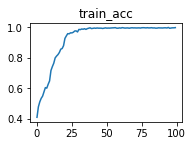

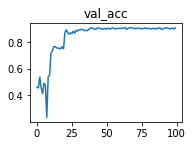

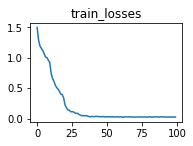

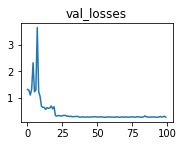

In [24]:
plt.subplot(2,2,1)
plt.plot(train_acc)
plt.title('train_acc')
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/acoustic_scene_classification_small/train_acc_mel_short_freeze_batch8_shuffled_cnn.png')

plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.title('val_acc')
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/acoustic_scene_classification_small/val_acc_mel_short_freeze_batch8_shuffled_cnn.png')

plt.subplot(2,2,3)
plt.plot(train_losses)
plt.title('train_losses')
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/acoustic_scene_classification_small/train_losses_mel_short_freeze_batch8_shuffled_cnn.png')

plt.subplot(2,2,4)
plt.plot(valid_losses)
plt.title('val_losses')
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/acoustic_scene_classification_small/valid_losses_mel_short_freeze_batch8_shuffled_cnn.png')


In [27]:
df = pd.read_pickle('/home/sauravpathak/acoustic_scene_classification_small/test_split_df.pkl')
test_data = AudioData(df, 'label')
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

100%|██████████| 358/358 [00:08<00:00, 41.85it/s]


In [30]:
with torch.no_grad():
    resnet_model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(test_loader):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y_hat = resnet_model(x)
        loss = loss_fn(y_hat, y)
        trace_y.append(y.cpu().detach().numpy())
        trace_yhat.append(y_hat.cpu().detach().numpy())      
        batch_losses.append(loss.item())
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    test_acc = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'test accuracy - {test_acc}')

test accuracy - 0.7458100558659218


In [29]:
from sklearn.metrics import classification_report

y_true = trace_y
y_pred = np.argmax(trace_yhat, axis=1)
#labels = [0,1,2,3,4,5,6]
target_names = ['airport',
 'bus',
 'metro',
 'park',
 'publicsquare',
 'shoppingmall',
 'streettraffic']

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(358,) (358,)
               precision    recall  f1-score   support

      airport       0.77      0.82      0.80        50
          bus       0.68      0.69      0.68        55
        metro       0.73      0.80      0.77        51
         park       0.88      0.90      0.89        50
 publicsquare       0.66      0.66      0.66        50
 shoppingmall       0.69      0.65      0.67        51
streettraffic       0.82      0.71      0.76        51

     accuracy                           0.75       358
    macro avg       0.75      0.75      0.75       358
 weighted avg       0.75      0.75      0.75       358

